In [1]:
import pandas
import seaborn
import time

from lib.compiler import Compiler
from lib.models.generic_v0.model import mappable_params

from lib.models.aft20barzur import BitcoinSM as AFT20BarZur
from lib.models.fc16sapirshtein import BitcoinSM as FC16Sapirshtein

from lib.models.generic_v1 import protocols as g1
from lib.models.generic_v1.model import SingleAgent as G1Model

from lib.models.generic_v0.bitcoin import Bitcoin as G0Bitcoin
from lib.models.generic_v0.model import SelfishMining as G0Model

In [2]:
network = mappable_params

models = []
implicit_mdps = []


def add_model(*, implicit_mdp, **model):
    models.append(model)
    implicit_mdps.append(implicit_mdp)


# related work baseline


def _():
    pass

    add_model(
        scenario="reference",
        model="fc16sapirshtein",
        force_consider_own=True,
        merge_isomorphic=True,
        truncate_common_chain=True,
        collect_garbage=True,
        reward_common_chain=True,
        protocol="bitcoin",
        implicit_mdp=lambda c: FC16Sapirshtein(
            **network, maximum_fork_length=c
        ),  # TODO implement DAG size cutoff for this model
    )

    add_model(
        scenario="reference-v0",
        model="generic_0",
        force_consider_own=True,
        merge_isomorphic=True,
        truncate_common_chain=True,
        collect_garbage=True,
        reward_common_chain=True,
        protocol="bitcoin",
        implicit_mdp=lambda c: G0Model(
            G0Bitcoin(),
            **network,
            maximum_size=c,
            force_consider_own=True,
            merge_isomorphic=True,
        ),
    )


# our baseline: garbage collection + common chain truncation
# we want to compare to:
# - no common chain truncation (all infinite)
# - no garbage collection (infinite for protocols that allow stale blocks)
# - plus force-consider-own
# - plus merge-isomorphic
# - plus both


def add_scenario(
    scenario,
    *,
    collect_garbage=True,
    truncate_common_chain=True,
    force_consider_own=False,
    merge_isomorphic=False,
):
    def f(protocol_s, protocol_C, **protocol_args):
        model_args = dict(
            force_consider_own=force_consider_own,
            merge_isomorphic=merge_isomorphic,
            truncate_common_chain=truncate_common_chain,
            collect_garbage=collect_garbage,
            reward_common_chain=False,
        )
        add_model(
            scenario=scenario,
            model="generic_1",
            protocol=protocol_s,
            **model_args,
            implicit_mdp=lambda c: G1Model(
                protocol_C,
                **protocol_args,
                **network,
                **model_args,
                dag_size_cutoff=c,
            ),
        )

    f("bitcoin", g1.Bitcoin)
    f("ethereum_3", g1.Ethereum, h=3)
    f("byzantium_3", g1.Byzantium, h=3)
    f("ghostdag_3", g1.Ghostdag, k=3)
    f("parallel_3", g1.Parallel, k=3)


add_scenario("baseline")
# add_scenario("w/o collect garbage", collect_garbage=False)  # for some reason I do not understand; this causes an infinite loop on bitcoin
# add_scenario("w/o truncate", truncate_common_chain=False)  # for some reason I do not understand; this causes an infinite loop on bitcoin
add_scenario("w/ force consider", force_consider_own=True)
add_scenario("w/ normalization", merge_isomorphic=True)
add_scenario("w/ both", force_consider_own=True, merge_isomorphic=True)

models = pandas.DataFrame(models)
models

,scenario,model,protocol,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain
0,baseline,generic_1,bitcoin,False,False,True,True,False
1,baseline,generic_1,ethereum_3,False,False,True,True,False
2,baseline,generic_1,byzantium_3,False,False,True,True,False
3,baseline,generic_1,ghostdag_3,False,False,True,True,False
4,baseline,generic_1,parallel_3,False,False,True,True,False
5,w/ force consider,generic_1,bitcoin,True,False,True,True,False
6,w/ force consider,generic_1,ethereum_3,True,False,True,True,False
7,w/ force consider,generic_1,byzantium_3,True,False,True,True,False
8,w/ force consider,generic_1,ghostdag_3,True,False,True,True,False
9,w/ force consider,generic_1,parallel_3,True,False,True,True,False


In [3]:
!mkdir -p 5-generated-mdps

In [4]:
from IPython.display import display, clear_output
import gc
import psutil
import pickle
import gzip

max_size = 100000
max_size = 10000
aborts = []
size_log = []


def get_rss():
    gc.collect()
    return psutil.Process().memory_info().rss / 1024**3  # GiB


for idx, row in models.iterrows():
    dag_size_limit = 1
    while True:
        dag_size_limit += 1
        m = implicit_mdps[idx](dag_size_limit)
        c = Compiler(m)
        start_time = time.monotonic()
        while not_done := c.explore(steps=1000):
            if c.n_states > max_size:
                break

        info = row.to_dict() | dict(
            dag_size_limit=dag_size_limit,
            size=c.n_states,
            time_spent=time.monotonic() - start_time,
            rss=get_rss(),
        )

        # report to stdout
        print(
            "\r"
            + "\t".join(
                [
                    f"{k}: {info[k]}"
                    for k in [
                        "scenario",
                        "protocol",
                        "dag_size_limit",
                        "size",
                        "time_spent",
                        "rss",
                    ]
                ]
                + [f"abort: {not_done}                      "]
            ),
            end="",
        )

        if not_done:
            aborts.append(info)
            break
        else:
            mdp_key = format(abs(hash(frozenset(info.items()))), "08x")[0:8]
            size_log.append(info | dict(mdp=mdp_key))
            with gzip.open(f"5-generated-mdps/mdp-{mdp_key}.pkl.gz", "wb") as f:
                pickle.dump(c.mdp(finish_exploration=False), f)

size_log = pandas.DataFrame(size_log)
aborts = pandas.DataFrame(aborts)

size_log.to_pickle("5-generated-mdps/success.pkl.gz")
aborts.to_pickle("5-generated-mdps/fail.pkl.gz")

scenario: w/ both	protocol: parallel_3	dag_size_limit: 10	size: 11219	time_spent: 13.664871741999377	rss: 0.301116943359375	abort: True                                  

In [5]:
aborts

,scenario,model,protocol,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,dag_size_limit,size,time_spent,rss
0,baseline,generic_1,bitcoin,False,False,True,True,False,6,10162,5.034728,0.251839
1,baseline,generic_1,ethereum_3,False,False,True,True,False,6,10511,5.454323,0.254307
2,baseline,generic_1,byzantium_3,False,False,True,True,False,6,10511,5.822179,0.256241
3,baseline,generic_1,ghostdag_3,False,False,True,True,False,6,10436,7.032685,0.252113
4,baseline,generic_1,parallel_3,False,False,True,True,False,7,10216,5.947019,0.263805
5,w/ force consider,generic_1,bitcoin,True,False,True,True,False,9,10008,7.225602,0.276409
6,w/ force consider,generic_1,ethereum_3,True,False,True,True,False,8,10089,7.135247,0.270622
7,w/ force consider,generic_1,byzantium_3,True,False,True,True,False,8,10046,8.223289,0.270580
8,w/ force consider,generic_1,ghostdag_3,True,False,True,True,False,8,10071,10.035645,0.265553
9,w/ force consider,generic_1,parallel_3,True,False,True,True,False,7,10242,5.840821,0.271431


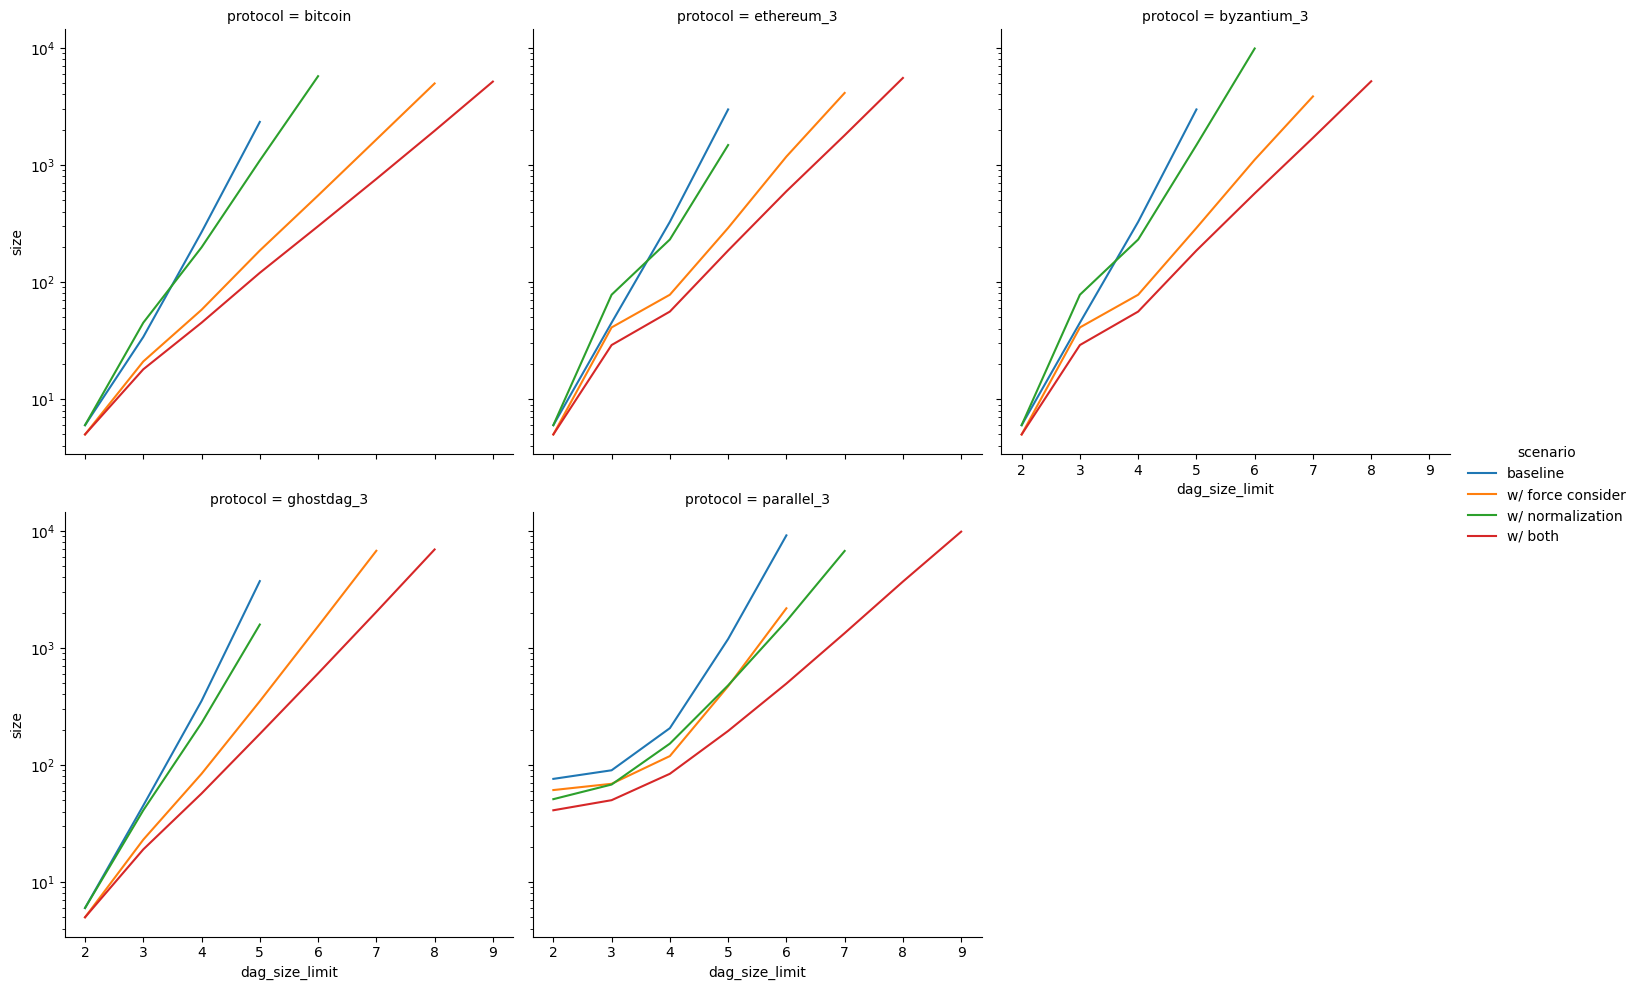

In [6]:
seaborn.relplot(
    data=size_log.query("dag_size_limit < 10"),
    kind="line",
    x="dag_size_limit",
    y="size",
    hue="scenario",
    col="protocol",
    col_wrap=3,
).set(yscale="log")